In [1]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 81.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from dataclasses import dataclass
import numpy as np
import random
import os
import wfdb
import random

@dataclass
class CFG:
    seed = 42
    records = [
        "100","101","102","103","104","105","106","107","108","109",
        "111","112","113","114","115","116","117","118","119","121",
        "122","123","124","200","201","202","203","205","207","208",
        "209","210","212","213","214","215","217","219","220","221",
        "222","223","228","230","231","232","233","234"
    ]
    window_sec = 2.0           # 2 sec @ 360 Hz → 720 samples
    crop_len = 720
    label_keep = ["N", "V"]    # Normal vs PVC
    train_ratio = 0.7
    val_ratio = 0.15
    test_ratio = 0.15
    split_mode = "record"
    batch_size = 64
    epochs = 25
    z_dim = 100
    device = "cuda" if torch.cuda.is_available() else "cpu"





In [10]:
def load_record(name, duration_sec=600):
    rec = wfdb.rdrecord(name, pn_dir="mitdb")
    ann = wfdb.rdann(name, "atr", pn_dir="mitdb")
    fs = rec.fs
    sig = rec.p_signal[:int(fs*duration_sec)]
    valid = ann.sample < int(fs*duration_sec)
    ann.sample = ann.sample[valid]
    ann.symbol = np.array(ann.symbol)[valid].tolist()
    return sig, ann, fs

def segment_beats(signal, ann, fs, window_sec, label_keep):
    half = int(fs * window_sec / 2)
    beats, labels = [], []

    for sample, sym in zip(ann.sample, ann.symbol):
        if sym not in label_keep:
            continue

        start, end = sample - half, sample + half
        if start < 0 or end > len(signal):
            continue

        seg = signal[start:end, 0]

        # z-score
        seg = (seg - seg.mean()) / (seg.std() + 1e-8)

        # scale to [-1, 1]
        seg = np.clip(seg, -5, 5) / 5.0

        beats.append(seg.astype(np.float32))
        labels.append(0 if sym == "N" else 1)

    if not beats:
        # If no beats were found, return empty arrays with the expected shape
        beat_len = int(fs * window_sec)
        return np.empty((0, beat_len), dtype=np.float32), np.empty((0,), dtype=np.int64)
    else:
        return np.stack(beats), np.array(labels, dtype=np.int64)


from sklearn.model_selection import train_test_split

def build_dataset(cfg):
    if getattr(cfg, "split_mode", "record") == "record":
        rng = np.random.default_rng(cfg.seed)
        records = list(cfg.records)
        rng.shuffle(records)
        n_total = len(records)
        n_train = int(n_total * cfg.train_ratio)
        n_val = int(n_total * cfg.val_ratio)
        train_recs = records[:n_train]
        val_recs = records[n_train:n_train + n_val]
        test_recs = records[n_train + n_val:]

        def proc(rec_list):
            xs, ys = [], []
            for r in rec_list:
                sig, ann, fs = load_record(r)
                x, y = segment_beats(sig, ann, fs, cfg.window_sec, cfg.label_keep)
                if x.size == 0 or y.size == 0:
                    continue
                if x.ndim == 1:
                    x = x[None, :]
                xs.append(x[:, None, :])
                ys.append(y)
            if len(xs) == 0:
                return np.empty((0, 1, cfg.crop_len)), np.empty((0,), dtype=int)
            return np.concatenate(xs, axis=0), np.concatenate(ys, axis=0)

        X_train, y_train = proc(train_recs)
        X_val, y_val = proc(val_recs)
        X_test, y_test = proc(test_recs)

    else:
        xs, ys = [], []
        for r in cfg.records:
            sig, ann, fs = load_record(r)
            x, y = segment_beats(sig, ann, fs, cfg.window_sec, cfg.label_keep)
            if x.size == 0 or y.size == 0:
                continue
            if x.ndim == 1:
                x = x[None, :]
            xs.append(x[:, None, :])
            ys.append(y)
        X = np.concatenate(xs, axis=0)
        y = np.concatenate(ys, axis=0)

        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y,
            test_size=cfg.val_ratio + cfg.test_ratio,
            stratify=y,
            random_state=cfg.seed
        )
        rel_test = cfg.test_ratio / (cfg.val_ratio + cfg.test_ratio)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp,
            test_size=rel_test,
            stratify=y_temp,
            random_state=cfg.seed
        )
    print("Class distribution:")
    for name, labels in zip(["Train", "Val", "Test"], [y_train, y_val, y_test]):
        if len(labels) > 0:
            ratio = np.mean(labels)
            print(f"{name}: {len(labels)} samples | pos ratio {ratio:.4f}")
        else:
            print(f"{name}: 0 samples")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)



class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, augment=False, cfg=CFG):
        self.X = torch.tensor(X.squeeze(), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

        self.cfg = cfg

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]

        return x.unsqueeze(0), y

In [11]:
(X_train, y_train), (_, _), (_, _) = build_dataset(CFG)

train_ds = ECGDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=CFG.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True
)


Class distribution:
Train: 18285 samples | pos ratio 0.0919
Val: 4574 samples | pos ratio 0.0317
Test: 4486 samples | pos ratio 0.0974


In [ ]:
class ECGGenerator(nn.Module):
    def __init__(self, z_dim=100, n_classes=2):
        super().__init__()

        self.embed = nn.Embedding(n_classes, z_dim)
        self.fc = nn.Linear(z_dim, 256 * 45)

        self.net = nn.Sequential(
            nn.ConvTranspose1d(256, 128, 4, 2, 1),  # 45 → 90
            nn.LayerNorm([128, 90]),
            nn.ReLU(),

            nn.ConvTranspose1d(128, 64, 4, 2, 1),   # 90 → 180
            nn.LayerNorm([64, 180]),
            nn.ReLU(),

            nn.ConvTranspose1d(64, 32, 4, 2, 1),    # 180 → 360
            nn.LayerNorm([32, 360]),
            nn.ReLU(),

            nn.ConvTranspose1d(32, 1, 4, 2, 1),     # 360 → 720
            nn.Tanh()
        )

    def forward(self, z, y):
        y_emb = self.embed(y)
        z = z + y_emb
        x = self.fc(z).view(-1, 256, 45)
        out = self.net(x)
        out = torch.clamp(out, -0.999, 0.999) # clamp to prevent spikes
        return out

In [24]:
class ECGDiscriminator(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()

        self.embed = nn.Embedding(n_classes, 256)

        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv1d(32, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv1d(64, 128, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv1d(128, 256, 4, 2, 1),
            nn.LeakyReLU(0.2),
        )

        self.fc = nn.Linear(256 * 45, 1)

    def forward(self, x, y):
        h = self.conv(x).view(x.size(0), -1)
        out = self.fc(h)

        # projection
        y_emb = self.embed(y)
        proj = torch.sum(h.view(h.size(0), 256, -1).mean(-1) * y_emb, dim=1, keepdim=True)

        return out + proj


In [ ]:
def gradient_penalty(D, real, fake, y, device):
    alpha = torch.rand(real.size(0), 1, 1, device=device)
    interp = (alpha * real + (1 - alpha) * fake).requires_grad_(True)

    d_interp = D(interp, y)
    grads = torch.autograd.grad(
        outputs=d_interp,
        inputs=interp,
        grad_outputs=torch.ones_like(d_interp),
        create_graph=True,
        retain_graph=True
    )[0]

    grads = grads.view(grads.size(0), -1)
    return ((grads.norm(2, dim=1) - 1) ** 2).mean()


def temporal_smoothness_loss(fake):
    return torch.mean(torch.abs(fake[:, :, 1:] - fake[:, :, :-1]))

In [ ]:
def train_wgan_gp(
    G, D, loader, device,
    epochs=100,
    z_dim=100,
    n_critic=5,
    gp_lambda=10,
    lambda_smooth=10.0
):
    G.to(device)
    D.to(device)

    opt_G = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.0, 0.9))
    opt_D = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.0, 0.9))

    for epoch in range(epochs):
        for i, (real, y) in enumerate(loader):
            real, y = real.to(device), y.to(device)
            bs = real.size(0)

            # discriminator step
            for _ in range(n_critic):
                z = torch.randn(bs, z_dim, device=device)
                fake = G(z, y)

                d_real = D(real, y).mean()
                d_fake = D(fake.detach(), y).mean()
                gp = gradient_penalty(D, real, fake, y, device)

                d_loss = d_fake - d_real + gp_lambda * gp

                opt_D.zero_grad()
                d_loss.backward()
                opt_D.step()

            # generator step
            z = torch.randn(bs, z_dim, device=device)
            fake = G(z, y)
            g_loss = -D(fake, y).mean()
            g_loss += lambda_smooth * temporal_smoothness_loss(fake)

            opt_G.zero_grad()
            g_loss.backward()
            opt_G.step()

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"D: {d_loss.item():.4f} | G: {g_loss.item():.4f}"
        )

In [33]:
torch.manual_seed(CFG.seed)

G = ECGGenerator(z_dim=CFG.z_dim, n_classes=2)
D = ECGDiscriminator(n_classes=2)

train_wgan_gp(
    G=G,
    D=D,
    loader=train_loader,
    device=CFG.device,
    epochs=CFG.epochs,
    z_dim=CFG.z_dim,
    n_critic=5,
    gp_lambda=10
)



Epoch [1/25] | D: -2.9768 | G: -18.9120
Epoch [2/25] | D: -2.7441 | G: -11.5929
Epoch [3/25] | D: -2.3325 | G: -3.6080
Epoch [4/25] | D: -1.7518 | G: 4.4999
Epoch [5/25] | D: -1.3739 | G: 8.5843
Epoch [6/25] | D: -1.2942 | G: 12.5918
Epoch [7/25] | D: -1.3251 | G: 19.7948
Epoch [8/25] | D: -1.0408 | G: 16.6901
Epoch [9/25] | D: -1.0827 | G: 13.6904
Epoch [10/25] | D: -0.9856 | G: 10.6107
Epoch [11/25] | D: -1.0243 | G: 7.2905
Epoch [12/25] | D: -0.9301 | G: 6.4624
Epoch [13/25] | D: -0.9192 | G: 3.3485
Epoch [14/25] | D: -0.9299 | G: 2.4848
Epoch [15/25] | D: -0.7542 | G: 1.7639
Epoch [16/25] | D: -0.7229 | G: -0.4683
Epoch [17/25] | D: -0.7329 | G: 1.0078
Epoch [18/25] | D: -0.7843 | G: 1.1932
Epoch [19/25] | D: -0.7166 | G: -0.2668
Epoch [20/25] | D: -0.7793 | G: 1.0739
Epoch [21/25] | D: -0.7054 | G: 1.1446
Epoch [22/25] | D: -0.7718 | G: 0.7717
Epoch [23/25] | D: -0.8108 | G: -0.3399
Epoch [24/25] | D: -0.7384 | G: -0.5821
Epoch [25/25] | D: -0.7216 | G: 0.0759


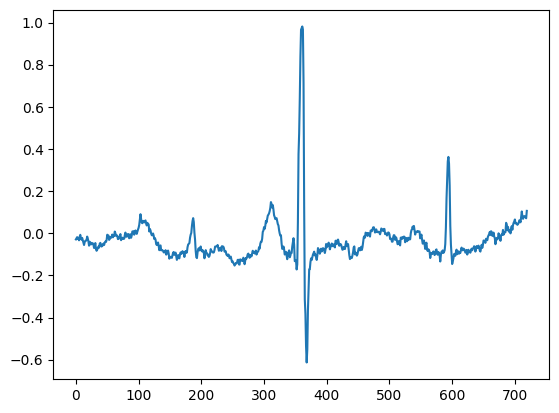

In [ ]:
G.eval()
z = torch.randn(1, 100).to(CFG.device)
y = torch.tensor([0]).to(CFG.device)
fake = G(z, y).detach().cpu().numpy()

fake = fake.squeeze()

fake.shape

plt.plot(fake[0])

In [35]:
import matplotlib.pyplot as plt

In [52]:
torch.save(G.state_dict(), "ecg_cond_wgan_generator.pt")
torch.save(D.state_dict(), "ecg_cond_wgan_discriminator.pt")
